<a href="https://colab.research.google.com/github/1zpzz/QM2-Website-/blob/main/Regression_Discontinuity_ESSA_%20Per_Pupil_Expenditure_School_Shootings_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import os
from google.colab import files

def download_and_process_csv(url):
    filename = os.path.basename(url)
    response = requests.get(url)

    with open(filename, "wb") as file:
        file.write(response.content)


    df = pd.read_csv(filename)

    return df

In [ ]:
# Reload the dataset to start fresh
population_df = download_and_process_csv("https://github.com/1zpzz/QM2---school-shooting-/raw/refs/heads/main/Public%20v3%20(4).csv")

# Ensure the 'Population' column is treated as a string to apply .str.replace()
population_df['Population'] = population_df['Population'].astype(str).str.replace(',', '', regex=False)

# Convert the cleaned 'Population' column to numeric
population_df['Population'] = pd.to_numeric(population_df['Population'], errors='coerce')

# Reload the original dataset to ensure 'Year' and 'State' columns are present
df = download_and_process_csv("https://github.com/1zpzz/QM2---school-shooting-/raw/refs/heads/main/Public%20v3%20(3).csv") # Reloading the original dataset

# Group shootings data by Year and State
grouped_shootings = df.groupby(['Year', 'State']).size().reset_index(name='Shooting_Count')

# Merge the shootings data with the population data
merged_df = pd.merge(grouped_shootings, population_df, on='State', how='left')


merged_df['Shootings_per_100k'] = (merged_df['Shooting_Count'] / merged_df['Population']) * 100000
pivot_table = merged_df.pivot(index='State', columns='Year', values='Shootings_per_100k')

# Replace NaN values with 0
pivot_table = pivot_table.fillna(0)

pivot_table.to_csv('shootings_per_100k_per_year.csv')

print("\nCleaned Dataset (Preview):")
print(pivot_table.head())


Cleaned Dataset (Preview):
Year       1966  1967      1968  1969      1970      1971      1972      1973  \
State                                                                           
AK     0.000000   0.0  0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
AL     0.000000   0.0  0.000000   0.0  0.000000  0.000000  0.000000  0.019575   
AR     0.000000   0.0  0.000000   0.0  0.032597  0.000000  0.000000  0.000000   
AZ     0.000000   0.0  0.000000   0.0  0.000000  0.013457  0.000000  0.000000   
CA     0.005133   0.0  0.002566   0.0  0.002566  0.002566  0.005133  0.012832   

Year       1974      1975  ...      2015      2016      2017      2018  \
State                      ...                                           
AK     0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.136350   
AL     0.000000  0.000000  ...  0.019575  0.039151  0.058726  0.078301   
AR     0.032597  0.000000  ...  0.065195  0.032597  0.032597  0.032597   
AZ     0.000000  0.000000  ...  0.

In [ ]:
spending_file = download_and_process_csv("https://github.com/1zpzz/QM2---school-shooting-/raw/refs/heads/main/df_ppcs_2007_2023.csv")    # File containing per-pupil spending (2007-2023)
spending_df = spending_file
spending_df.rename(columns={'Geographic area': 'State'}, inplace=True)
STATE_TO_ABBREV = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}
spending_df['State'] = spending_df['State'].map(STATE_TO_ABBREV)

                            WLS Regression Results                            
Dep. Variable:              Shootings   R-squared:                       0.376
Model:                            WLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     173.6
Date:                Sat, 18 Jan 2025   Prob (F-statistic):           4.92e-88
Time:                        14:40:04   Log-Likelihood:                 1637.9
No. Observations:                 867   AIC:                            -3268.
Df Residuals:                     863   BIC:                            -3249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0131      0.004      3.509

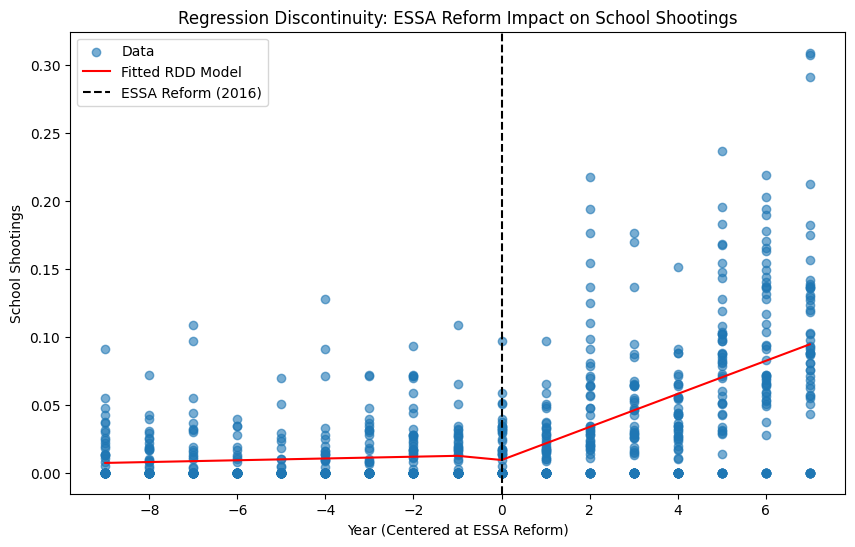

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

shootings_file = 'shootings_per_100k_per_year.csv'
spending_file = download_and_process_csv("https://github.com/1zpzz/QM2---school-shooting-/raw/refs/heads/main/df_ppcs_2007_2023.csv")
shootings_df = pd.read_csv(shootings_file)

shootings_long = shootings_df.melt(id_vars=['State'], var_name='Year', value_name='Shootings')
shootings_long['Year'] = shootings_long['Year'].astype(float).astype(int)

spending_long = spending_df.melt(id_vars=['State'], var_name='Year', value_name='Spending')
spending_long['Year'] = spending_long['Year'].str.extract('(\d+)').astype(int)

data = pd.merge(shootings_long, spending_long, on=['State', 'Year'])

# Ensure the dataset contains years (2007-2023) and valid data
data = data[(data['Year'] >= 2007) & (data['Year'] <= 2023)]

# Define the threshold year (ESSA reform: 2016)
threshold_year = 2016

# Create a variable for spending centered around the threshold year
data['Year_centered'] = data['Year'] - threshold_year

# Create a threshold dummy variable (1 if year is after or in 2016, 0 otherwise)
data['After_ESSA'] = (data['Year'] >= threshold_year).astype(int)

# Interaction term for the regression model
data['Interaction'] = data['Year_centered'] * data['After_ESSA']


model = smf.wls("Shootings ~ Year_centered + After_ESSA + Interaction", data).fit()
print(model.summary())
plt.figure(figsize=(10, 6))
plt.scatter(data['Year_centered'], data['Shootings'], alpha=0.6, label='Data')

plt.plot(
    data['Year_centered'],
    model.predict(data),
    color='red',
    label='Fitted RDD Model',
)

plt.axvline(0, color='black', linestyle='--', label='ESSA Reform (2016)')
plt.title('Regression Discontinuity: ESSA Reform Impact on School Shootings')
plt.xlabel('Year (Centered at ESSA Reform)')
plt.ylabel('School Shootings')
plt.legend()
plt.show()

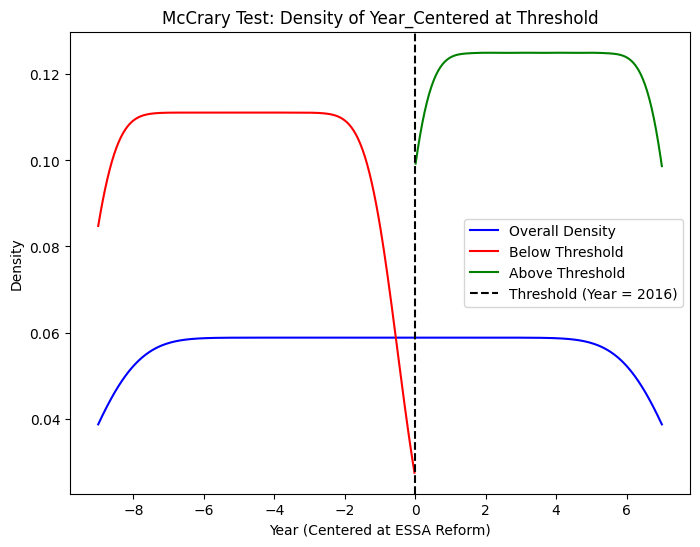

Density just below the threshold: 0.0268
Density just above the threshold: 0.0993
Discontinuity Ratio (Above/Below): 3.6983


In [ ]:
from scipy.stats import gaussian_kde

running_variable = data['Year_centered']

kde = gaussian_kde(running_variable)

x_vals = np.linspace(running_variable.min(), running_variable.max(), 500)
y_vals = kde(x_vals)

below_threshold = running_variable[running_variable < 0]
above_threshold = running_variable[running_variable >= 0]

kde_below = gaussian_kde(below_threshold)
kde_above = gaussian_kde(above_threshold)

plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label='Overall Density', color='blue')
plt.plot(x_vals[x_vals < 0], kde_below(x_vals[x_vals < 0]), label='Below Threshold', color='red')
plt.plot(x_vals[x_vals >= 0], kde_above(x_vals[x_vals >= 0]), label='Above Threshold', color='green')
plt.axvline(0, color='black', linestyle='--', label='Threshold (Year = 2016)')
plt.title('McCrary Test: Density of Year_Centered at Threshold')
plt.xlabel('Year (Centered at ESSA Reform)')
plt.ylabel('Density')
plt.legend()
plt.show()

density_below = kde_below(-0.01)
density_above = kde_above(0.01)

discontinuity_ratio = density_above / density_below
print(f"Density just below the threshold: {density_below[0]:.4f}")
print(f"Density just above the threshold: {density_above[0]:.4f}")
print(f"Discontinuity Ratio (Above/Below): {discontinuity_ratio[0]:.4f}")